# Import Libraries

In [1]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc
import tensorflow as tf
import random as rn
import numpy as np 
import os
import pickle

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for numpy-generated random numbers
np.random.seed(45)
# Setting the graph-level random seed.
tf.set_random_seed(1337)
rn.seed(73)

In [3]:
from keras import backend as K 
session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=1,
      inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

K.set_session(sess)
import math 
import pandas as pd

import keras
from keras import backend as K 
from keras.models import Sequential 
from keras.layers import InputLayer, Input
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import TensorBoard, EarlyStopping 
from keras.optimizers import Adam, Adamax
from keras.models import load_model 
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import sys

Using TensorFlow backend.


# Initialize Validation Data

In [4]:
fold = 1
feature_type = "pcawg_mutations_complete.csv"

path_best_model = './crossvalidation%s_best_model.keras'%fold
best_accuracy = 0.0 
data = pd.read_csv(feature_type, index_col = [0])

### Making training, test, validation data 
training_samples = pd.read_csv('./training_idx_pcawg.csv', index_col=[0])
training_samples.columns = ['guid', 'split']
training_samples = training_samples[training_samples.split == fold]
training_data = data[data['guid'].isin(training_samples.guid)]
validation_samples = pd.read_csv('./validation_idx_pcawg.csv', index_col=[0])
validation_samples.columns = ['guid', 'split']
validation_samples = validation_samples[validation_samples.split == fold]
validation_data = data[data['guid'].isin(validation_samples.guid)]
test_samples = pd.read_csv('./test_idx_pcawg.csv', index_col=[0])
test_samples.columns = ['guid', 'split']
test_samples = test_samples[test_samples.split == fold]
test_data = data[data['guid'].isin(test_samples.guid)]

training_data = training_data.drop(['guid'], axis = 1)
validation_data = validation_data.drop(['guid'], axis = 1)
test_data = test_data.drop(['guid'], axis = 1)

x_train = training_data.values
y_train = training_data.index
x_val = validation_data.values
y_val = validation_data.index
x_test = test_data.values
y_test = test_data.index 

encoder = LabelEncoder()
test_labels_names = y_test
y_test = encoder.fit_transform(y_test)
test_labels = y_test
y_test = keras.utils.to_categorical(y_test, 24)
y_train = encoder.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train, 24)
y_val = encoder.fit_transform(y_val)
y_val = keras.utils.to_categorical(y_val, 24)

validation_data = (x_val, y_val)

input_size = x_train.shape[1]

# Create DeepLIFT Scores

In [5]:
num_classes = 24
deeplift_model = kc.convert_model_from_saved_files('./crossvalidation_results/fold_%s_model.keras'%fold, nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 
new0 = deeplift_model.get_target_contribs_func( find_scores_layer_idx=0)
scores = []
for i in range(num_classes):
    scores.append(np.array(new0(task_idx=i, input_data_list=[x_test],  batch_size=5, progress_update=1000)))
#mymodel = load_model('./crossvalidation_results/fold_%s_model.keras'%fold)


nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
Encountered an Input layer in sequential container; skipping due to redundancy
For layer 1 the preceding linear layer is preact_1 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 3 the preceding linear layer is preact_3 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 5 the preceding linear layer is preact_5 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 7 the preceding linear layer is preact_7 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will pri

# Save Scores

In [6]:
pickle.dump( scores, open( "scores.p", "wb" ) )

In [7]:
scores = pickle.load(open( "scores.p", "rb" ))

# Get Highest Absolute Value Features

In [8]:
abs_features_csv = ""
for score in scores:
	temp_score = np.absolute(np.average(score, axis=0))
	sorted_score = (-temp_score).argsort()[:30]
	for i in range(len(sorted_score)):
		if (i != len(sorted_score) - 1):
			abs_features_csv += (str(sorted_score[i]) + ",")
		else:
			abs_features_csv += (str(sorted_score[i]) + '\n')
with open("all.csv", "w") as text_file:
    text_file.write(abs_features_csv)

# Get Highest Value Features

In [9]:
pos_features_csv = ""
for score in scores:
	temp_score = np.average(score, axis=0)
	sorted_score = (-temp_score).argsort()[:30]
	for i in range(len(sorted_score)):
		if (i != len(sorted_score) - 1):
			pos_features_csv += (str(sorted_score[i]) + ",")
		else:
			pos_features_csv += (str(sorted_score[i]) + '\n')
with open("pos.csv", "w") as text_file:
    text_file.write(pos_features_csv)

# Get Lowest Value Features

In [10]:
neg_features_csv = ""
for score in scores:
	temp_score = np.average(score, axis=0)
	sorted_score = (temp_score).argsort()[:30]
	for i in range(len(sorted_score)):
		if (i != len(sorted_score) - 1):
			neg_features_csv += (str(sorted_score[i]) + ",")
		else:
			neg_features_csv += (str(sorted_score[i]) + '\n')
with open("neg.csv", "w") as text_file:
    text_file.write(neg_features_csv)

In [11]:
all_classes = ["Bone-Osteosarc","Breast-AdenoCA","CNS-GBM",
               "CNS-Medullo","CNS-PiloAstro","ColoRect-AdenoCA",
               "Eso-AdenoCA","Head-SCC","Kidney-ChRCC","Kidney-RCC",
               "Liver-HCC","Lung-AdenoCA","Lung-SCC","Lymph-BNHL",
               "Lymph-CLL","Myeloid-MPN","Ovary-AdenoCA","Panc-AdenoCA",
               "Panc-Endocrine","Prost-AdenoCA","Skin-Melanoma",
               "Stomach-AdenoCA","Thy-AdenoCA","Uterus-AdenoCA"]

# Plot all genomic bins and feature score for each class

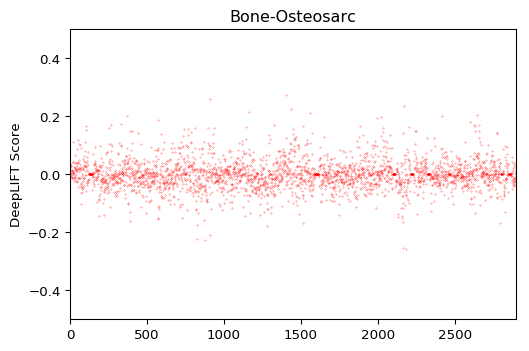

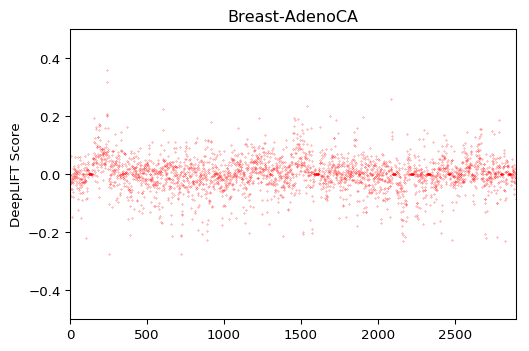

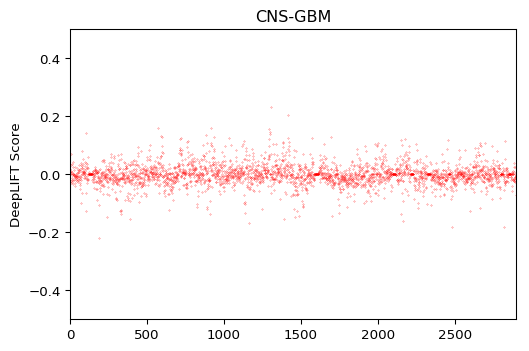

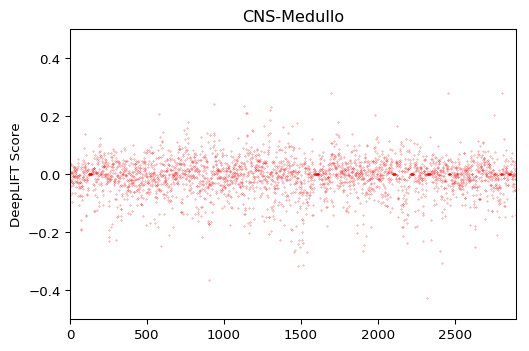

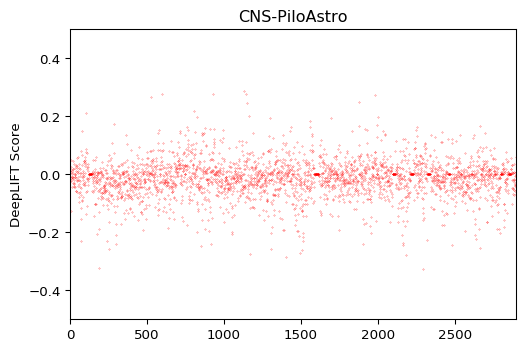

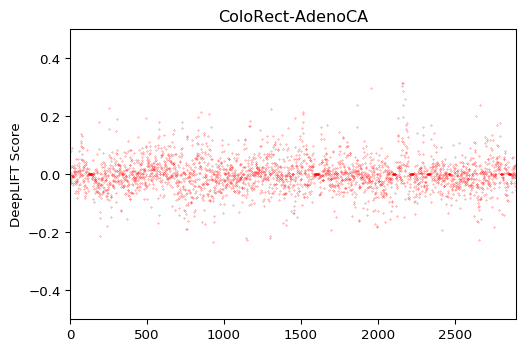

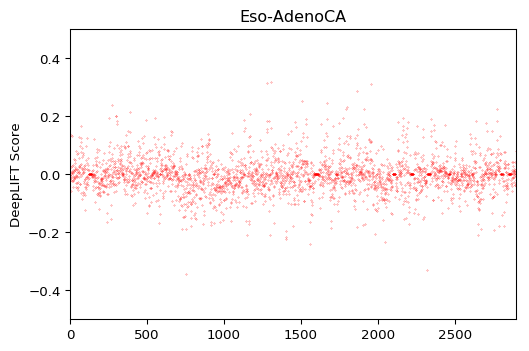

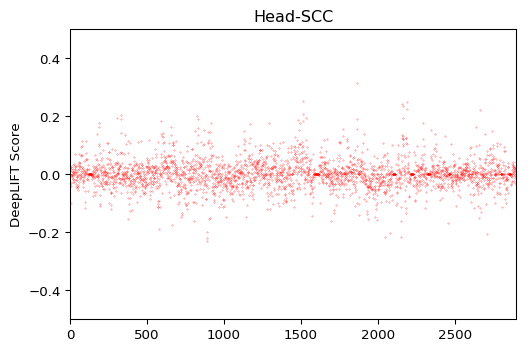

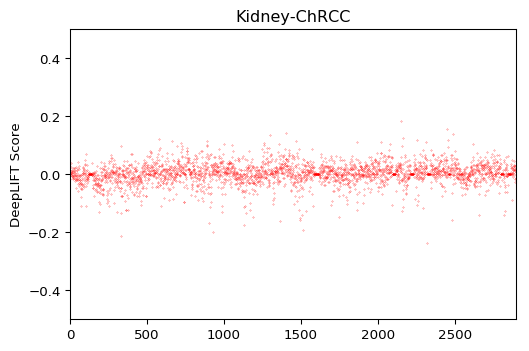

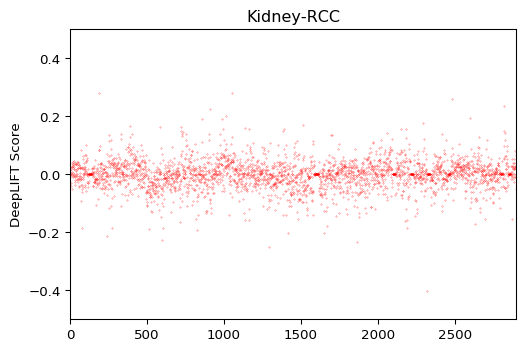

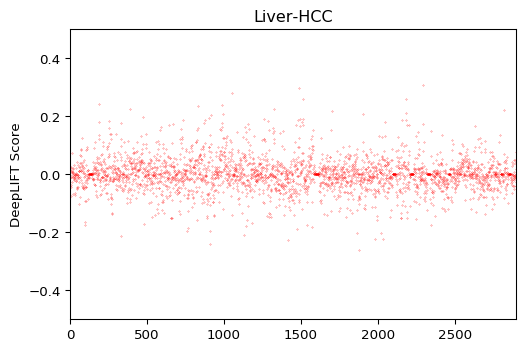

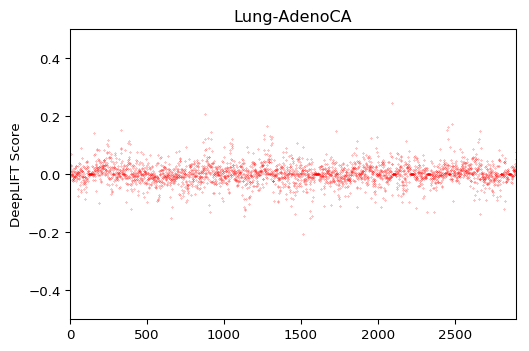

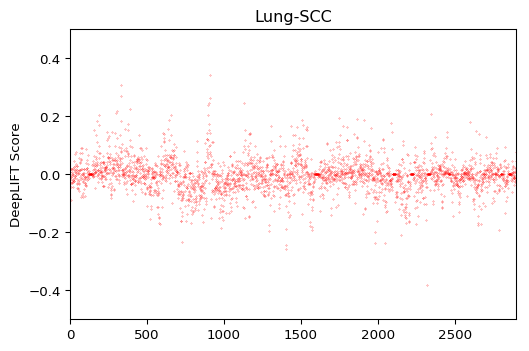

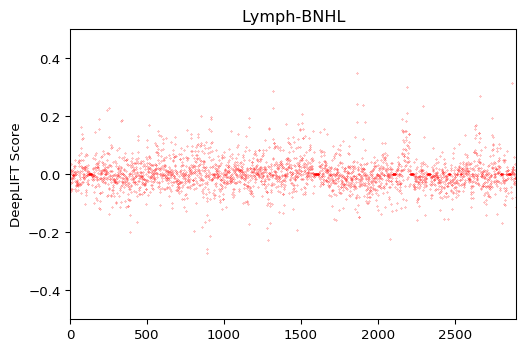

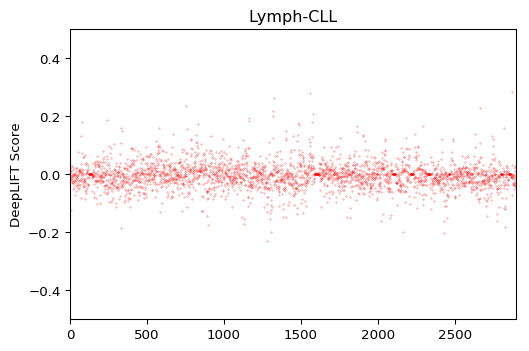

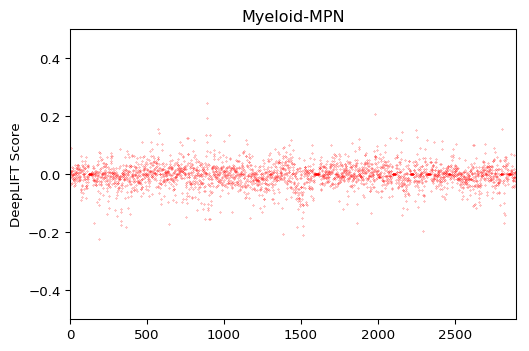

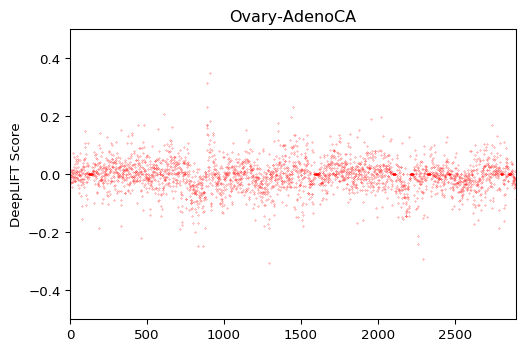

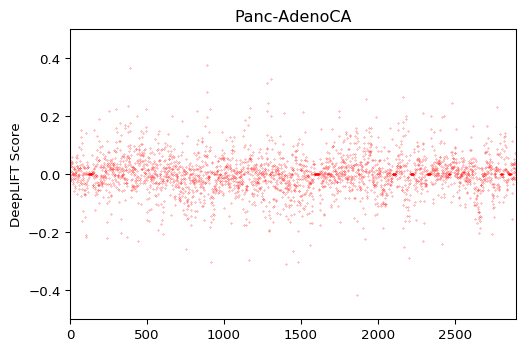

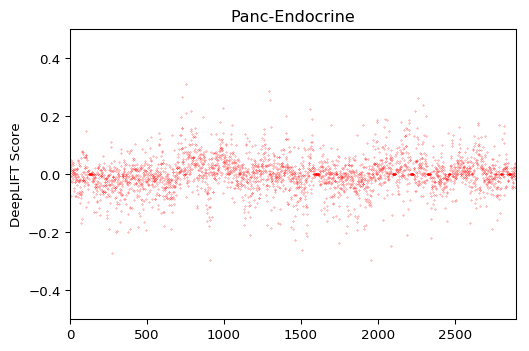

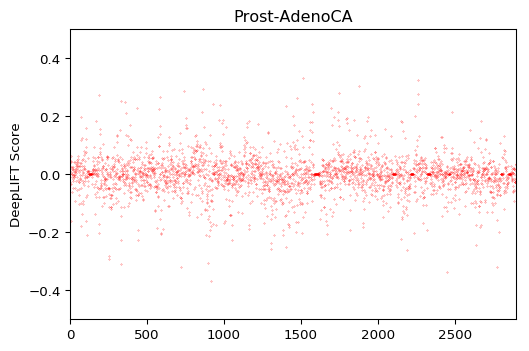

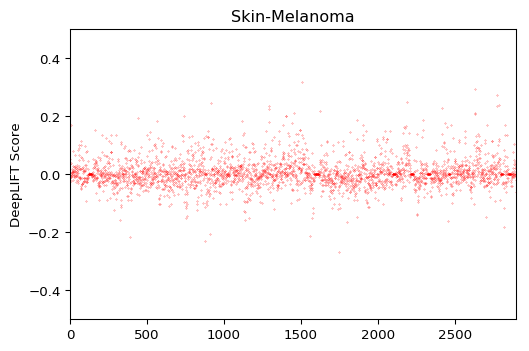

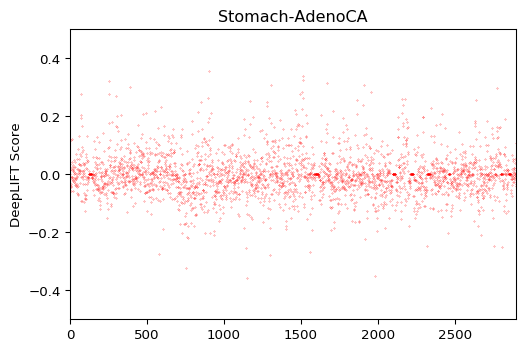

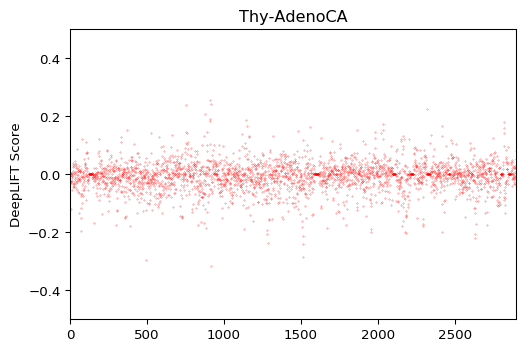

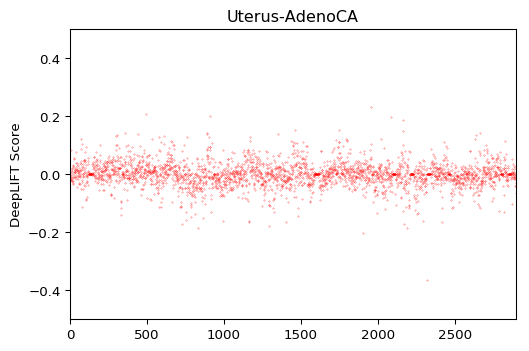

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 96
for i in range(len(scores)):
    class_0_avg = np.average(scores[i], axis=0)
    x_vals = list(range(1,len(class_0_avg) + 1))
    y_vals = class_0_avg
    x_vals[:2897]
    plt.plot(x_vals[:2897], y_vals[:2897], 'ro', markersize=0.2)
    plt.axis([0, 2897, -0.5, 0.5])
    plt.title(all_classes[i])
    plt.ylabel('DeepLIFT Score')
    plt.show()

# Substitution Classes Aren't very Useful

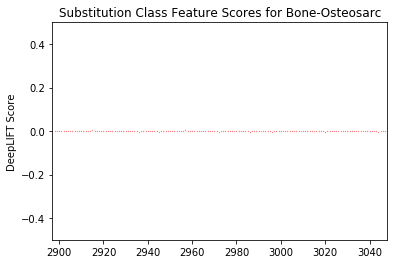

In [13]:
plt.plot(list(range(1, len(np.average(scores[0], axis=0)) + 1))[2897:], np.average(scores[0], axis=0)[2897:], 'ro', markersize=0.2)
plt.axis([2897, 3048, -0.5, 0.5])
plt.ylabel('DeepLIFT Score')
plt.title("Substitution Class Feature Scores for Bone-Osteosarc")
plt.show()